In [1]:
# Final Script to create plots to put into the documentation.

import os
import uuid
import zipfile
from os.path import join, dirname
from tempfile import gettempdir
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

from aequilibrae import TrafficAssignment, TrafficClass, Graph, Project, ODME
from tests.data import siouxfalls_project

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.environ["PATH"] = os.path.join(gettempdir(), "temp_data") + ";" + os.environ["PATH"]
proj_path = os.path.join(gettempdir(), "test_odme_files" + uuid.uuid4().hex)
os.mkdir(proj_path)
zipfile.ZipFile(join(dirname(siouxfalls_project), "sioux_falls_single_class.zip")).extractall(proj_path)

project = Project()
project.open(proj_path)
project.network.build_graphs()
car_graph = project.network.graphs["c"]  # type: Graph

car_graph.set_graph("free_flow_time")
car_graph.set_blocked_centroid_flows(False)
matrix = project.matrices.get_matrix("demand_aem")
matrix.computational_view() # Make sure to set the computational view appropriately.

In [3]:
assignment = TrafficAssignment()
assignclass = TrafficClass("car", car_graph, matrix)
assignment.set_classes([assignclass])
assignment.set_vdf("BPR")
assignment.set_vdf_parameters({"alpha": 0.15, "beta": 4.0})
assignment.set_vdf_parameters({"alpha": "b", "beta": "power"})
assignment.set_capacity_field("capacity")
assignment.set_time_field("free_flow_time")
assignment.max_iter = 5

# NOTE - Until Issue #493 is resolved algorithms cfw & bfw cannot be used for assignment.
assignment.set_algorithm("msa")

In [4]:
assignment.execute()
assign_df = assignment.results().reset_index(drop=False).fillna(0)
flow = lambda link: assign_df.loc[assign_df["link_id"] == link, "matrix_ab"].values[0]

# The set of links for our counts:
links = [i for i in assign_df['link_id'].to_numpy() if not i % 8]

# The columns to our data dataframe must be: 'class', 'link_id', 'direction', 'obs_volume'
# where 'obs_volume' is the count data.
columns = ODME.COUNT_VOLUME_COLS

# Synthetically generated data (changing counts by upto a 5% increase):
random.seed(0)
data = [["car", link, 1, flow(link) * random.uniform(1, 1.01)] for link in links]

counts = pd.DataFrame(data=data, columns=columns)

In [5]:
# We will run a quick ODME procedure:
stop_crit = {"max_outer": 20,
    "max_inner": 50,
    "convergence_crit": 0.1,
    "inner_convergence": 0.01}

odme = ODME(assignment,
    counts,
    stop_crit=stop_crit,
    alpha = 0.1,
    algorithm="gmean"
    )

In [6]:
odme.execute(verbose=True, print_rate=2) # Verbose/print_rate allow us to track the progress of ODME as it occurs

Outer iteration 2 is complete.
Outer iteration 4 is complete.
Outer iteration 6 is complete.
Outer iteration 8 is complete.
Outer iteration 10 is complete.
Outer iteration 12 is complete.
Outer iteration 14 is complete.
Outer iteration 16 is complete.
Outer iteration 18 is complete.
Outer iteration 20 is complete.


In [7]:
stats_spiess = odme.results.get_link_statistics()
iter_spiess = odme.results.get_iteration_statistics()

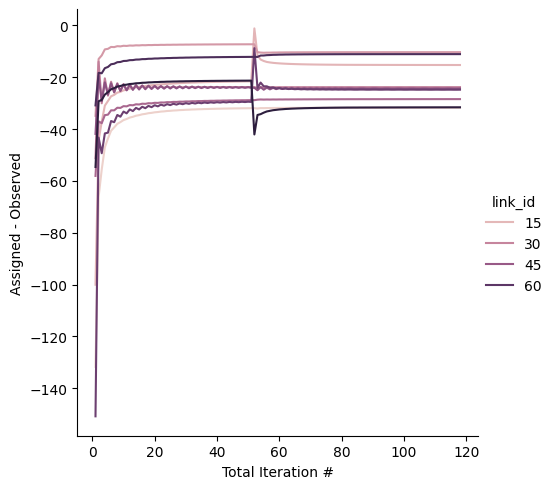

In [8]:
sns.relplot(x='Total Iteration #',
    y='Assigned - Observed',
    hue='link_id', 
    kind='line', 
    data=stats_spiess, 
    markers=True, 
    dashes=False)

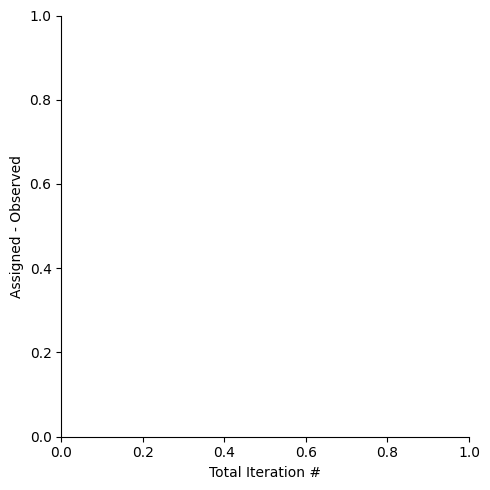

In [9]:
selected_ids = [1, 30, 52]

sns.relplot(x='Total Iteration #',
    y='Assigned - Observed',
    hue='link_id', 
    kind='line', 
    data=stats_spiess[stats_spiess['link_id'].isin(selected_ids)], 
    markers=True, 
    dashes=False)

In [10]:
# Plotting all count volumes:

sns.relplot(x='Total Iteration #',
    y='Assigned - Observed',
    hue='link_id', 
    kind='line', 
    data=stats_rsp, 
    markers=True, 
    dashes=False)

NameError: name 'stats_rsp' is not defined

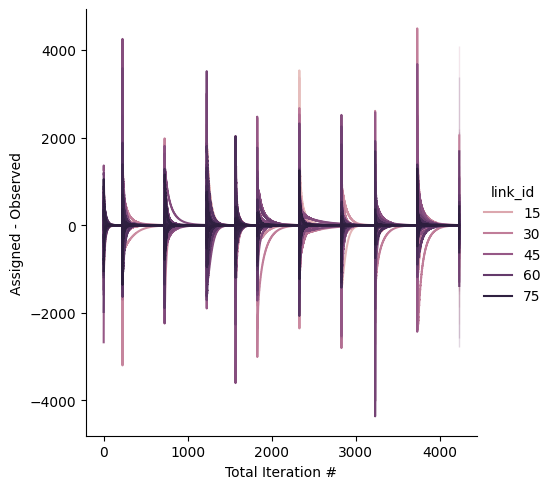

In [ ]:
# Plotting all count volumes:

sns.relplot(x='Total Iteration #',
    y='Assigned - Observed',
    hue='link_id', 
    kind='line', 
    data=stats_spiess, 
    markers=True, 
    dashes=False)

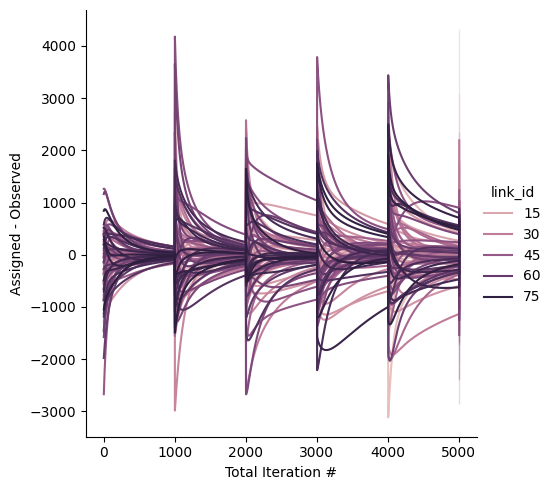

In [ ]:
# Plotting all count volumes:

sns.relplot(x='Total Iteration #',
    y='Assigned - Observed',
    hue='link_id', 
    kind='line', 
    data=stats_gmean, 
    markers=True, 
    dashes=False)

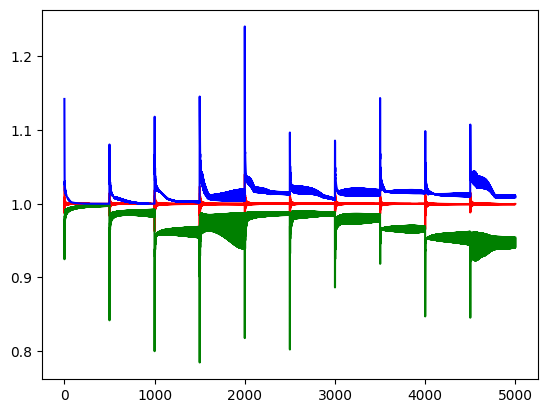

In [ ]:
plt.plot(factors_rsp['Total Inner Iteration #'], factors_rsp['mean'], color="red")
plt.plot(factors_rsp['Total Inner Iteration #'], factors_rsp['min'], color="green")
plt.plot(factors_rsp['Total Inner Iteration #'], factors_rsp['max'], color="blue")

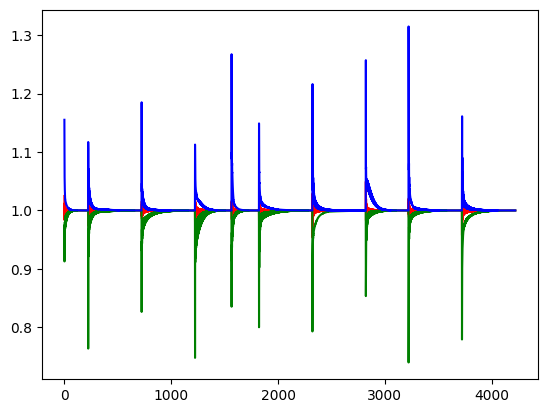

In [ ]:
plt.plot(factors_spiess['Total Inner Iteration #'], factors_spiess['mean'], color="red")
plt.plot(factors_spiess['Total Inner Iteration #'], factors_spiess['min'], color="green")
plt.plot(factors_spiess['Total Inner Iteration #'], factors_spiess['max'], color="blue")

In [ ]:
stats_rsp['Total Run Time (s)'].tail()

380831    28.389967
380832    28.389967
380833    28.389967
380834    28.389967
380835    28.389967
Name: Total Run Time (s), dtype: float64

In [ ]:
stats_spiess['Total Run Time (s)'].tail()

321703    37.018762
321704    37.018762
321705    37.018762
321706    37.018762
321707    37.018762
Name: Total Run Time (s), dtype: float64

In [ ]:
cumulative_factors_rsp["Factors"].describe()

count    5.760000e+02
mean     9.601060e-01
std      4.587254e-01
min      2.455179e-42
25%      7.867807e-01
50%      1.000000e+00
75%      1.120550e+00
max      3.388543e+00
Name: Factors, dtype: float64

In [ ]:
cumulative_factors_spiess["Factors"].describe()

count    576.000000
mean       1.079612
std        1.166257
min        0.008241
25%        0.342429
50%        0.829010
75%        1.375631
max       11.713580
Name: Factors, dtype: float64

<Axes: xlabel='Factors', ylabel='Count'>

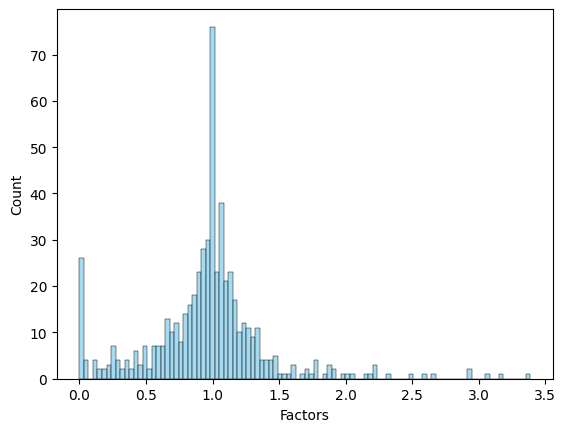

In [ ]:
sns.histplot(cumulative_factors_rsp['Factors'], bins=100, kde=False, color='skyblue')

<Axes: xlabel='Factors', ylabel='Count'>

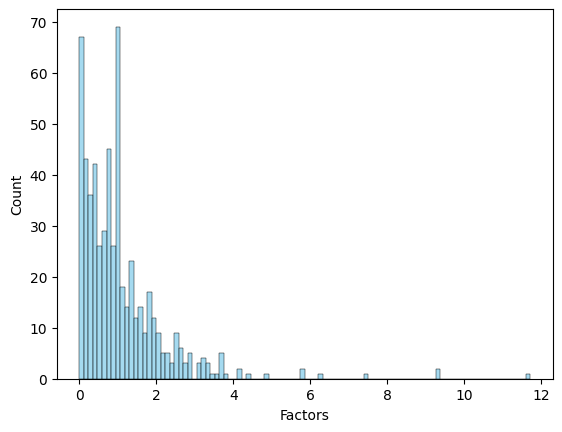

In [ ]:
sns.histplot(cumulative_factors_spiess['Factors'], bins=100, kde=False, color='skyblue')

<Axes: xlabel='Factors', ylabel='Count'>

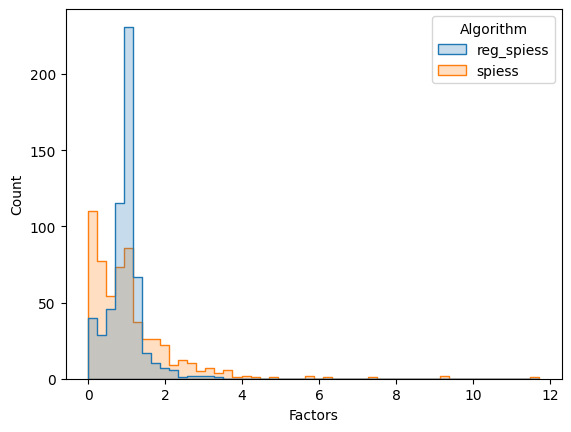

In [ ]:
# Reload factors:
cumulative_factors_spiess = pd.read_csv("/workspaces/aequilibrae/odme_stats/stats_cumulative_factors_spiess.csv", index_col=0)
cumulative_factors_rsp = pd.read_csv("/workspaces/aequilibrae/odme_stats/stats_cumulative_factors_reg_spiess.csv", index_col=0)

# Rename columns
cumulative_factors_rsp.rename(columns={'Factors': 'reg_spiess'}, inplace=True)
cumulative_factors_spiess.rename(columns={'Factors': 'spiess'}, inplace=True)
cumulative_factors_rsp.drop('class', axis=1, inplace=True)
cumulative_factors_spiess.drop('class', axis=1, inplace=True)

# Merge data:
merged_cumulative_factors = cumulative_factors_rsp.join(cumulative_factors_spiess)
merged_cumulative_factors = pd.melt(merged_cumulative_factors, var_name='Algorithm', value_name='Factors')

# Create plot
sns.histplot(data=merged_cumulative_factors, x='Factors', bins=50, kde=False, hue='Algorithm', element='step', stat='count')

In [ ]:
cumulative_factors_spiess = pd.read_csv("/workspaces/aequilibrae/odme_stats/stats_cumulative_factors_spiess.csv", index_col=0)
cumulative_factors_spiess

,class,Factors
0,car,1.000000
1,car,0.994475
2,car,2.861994
3,car,1.248865
4,car,1.927733
...,...,...
571,car,1.133172
572,car,0.124126
573,car,0.328496
574,car,1.883731


In [ ]:
new_demand_diff = new_demand_spiess - new_demand_gmean
new_demand_diff.drop('Unnamed: 0', axis=1, inplace=True)
new_demand_diff.describe()

,Demands
count,576.000000
mean,46.790955
std,706.779922
min,-3063.906956
25%,-169.224747
50%,0.000000
75%,146.179188
max,6137.066379


<Axes: >

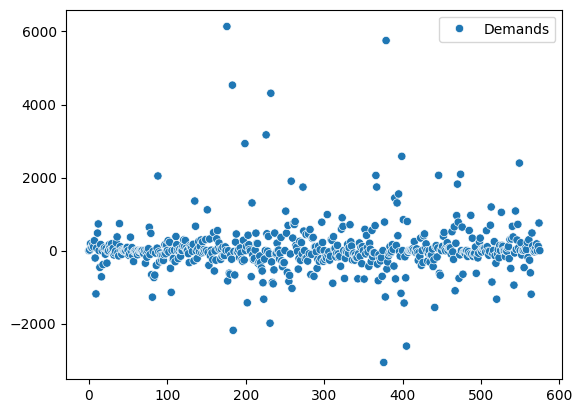

In [ ]:
sns.scatterplot(new_demand_diff)

In [ ]:
new_demand_prop = new_demand_spiess / new_demand_gmean
new_demand_inv_prop = new_demand_gmean / new_demand_spiess
new_demand_prop.drop('Unnamed: 0', axis=1, inplace=True)
new_demand_inv_prop.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
new_demand_prop.describe()

,Demands
count,528.000000
mean,1.182382
std,1.047788
min,0.006340
25%,0.427936
50%,0.918820
75%,1.613919
max,7.333243


In [ ]:
new_demand_inv_prop.describe()

,Demands
count,528.000000
mean,3.501545
std,11.213734
min,0.136365
25%,0.619610
50%,1.088354
75%,2.337092
max,157.720912


<Axes: >

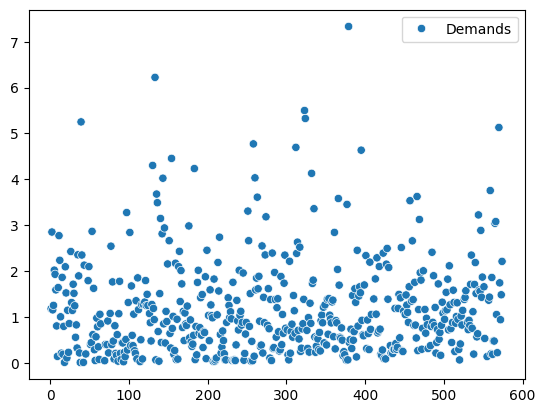

In [ ]:
sns.scatterplot(new_demand_prop)

<Axes: >

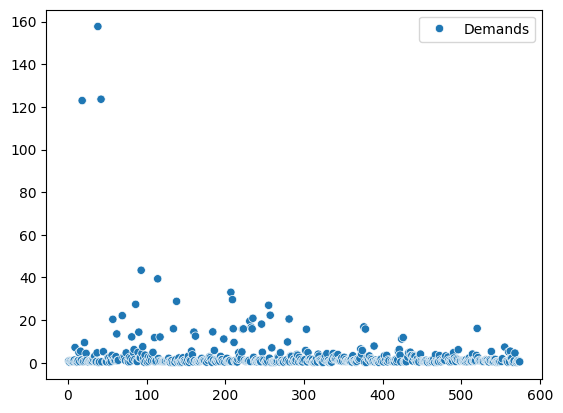

In [ ]:
sns.scatterplot(new_demand_inv_prop)

In [ ]:
new_demand_weighted_diff = (new_demand_spiess - new_demand_gmean) / new_demand_spiess
new_demand_weighted_diff = new_demand_weighted_diff.rename(columns={'Demands': 'Demands2'})
new_demand_weighted_diff.drop('Unnamed: 0', axis=1, inplace=True)
new_demand_weighted_diff.describe()

,Demands2
count,528.000000
mean,-2.501545
std,11.213734
min,-156.720912
25%,-1.337092
50%,-0.088354
75%,0.380390
max,0.863635


<Axes: >

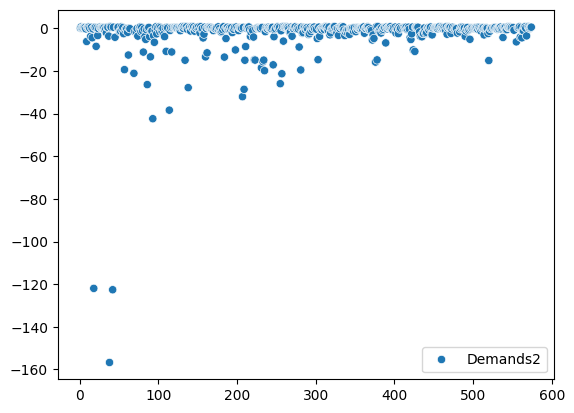

In [ ]:
sns.scatterplot(new_demand_weighted_diff)

<Axes: >

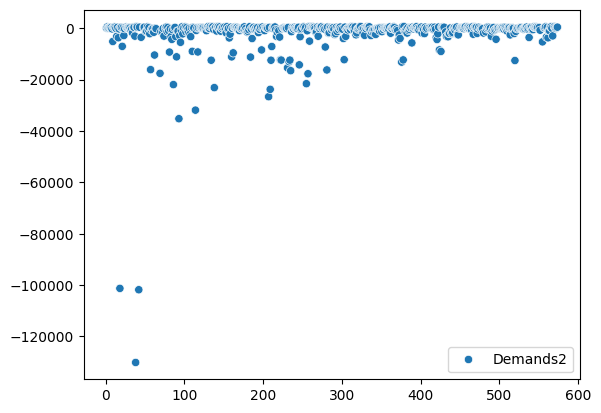

In [ ]:
new_demand_weighted_scaled_diff = new_demand_weighted_diff * 23.422653 / 0.028200
new_demand_weighted_scaled_diff = new_demand_weighted_scaled_diff.rename(columns={'Demands': 'Demands1'})
sns.scatterplot(new_demand_weighted_scaled_diff)

In [ ]:
new_demand_combine = pd.concat([new_demand_diff, new_demand_weighted_scaled_diff], axis=1)
new_demand_combine = new_demand_combine.rename(columns={'Demands': 'Demands Diff', 'Demands1': 'Demands Scaled Prop'})
new_demand_combine.describe()

,Demands Diff,Demands2
count,576.000000,528.000000
mean,46.790955,-2077.759715
std,706.779922,9314.021671
min,-3063.906956,-130170.905849
25%,-169.224747,-1110.576164
50%,0.000000,-73.385606
75%,146.179188,315.948335
max,6137.066379,717.326799


In [ ]:
new_demand_combine2 = pd.concat([new_demand_diff, new_demand_weighted_diff], axis=1)
new_demand_combine2 = new_demand_combine2.rename(columns={'Demands': 'Demands Diff', 'Demands2': 'Demands Prop'})
new_demand_combine2.describe()

,Demands Diff,Demands Prop
count,576.000000,528.000000
mean,46.790955,-2.501545
std,706.779922,11.213734
min,-3063.906956,-156.720912
25%,-169.224747,-1.337092
50%,0.000000,-0.088354
75%,146.179188,0.380390
max,6137.066379,0.863635


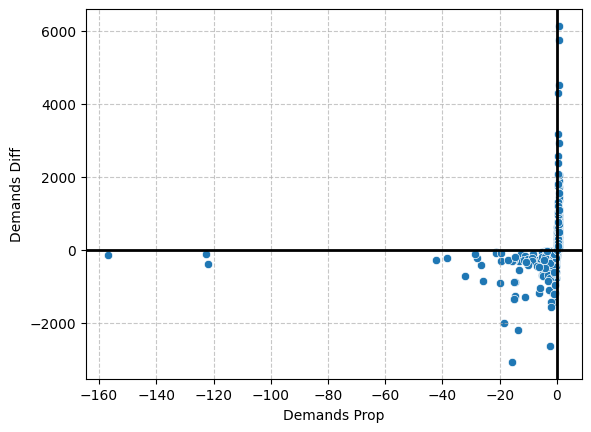

In [ ]:
sns.scatterplot(new_demand_combine2, x='Demands Prop', y='Demands Diff')
# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Add bold gridlines for x=0 and y=0
plt.axhline(0, color='black', linewidth=2)
plt.axvline(0, color='black', linewidth=2)

In [ ]:
stats_3 = pd.read_csv("/workspaces/aequilibrae/odme_stats/stats_3_vols.csv", index_col=0)
factors_3 = pd.read_csv("/workspaces/aequilibrae/odme_stats/stats_3_factors.csv", index_col=0)
# The total iteration number where each outer iteration begins
total_iter_outers = stats_3[stats_3["Inner Loop #"] == 0]["Total Iteration #"]
time_outers = stats_3[stats_3["Inner Loop #"] == 0]["Total Run Time (s)"]

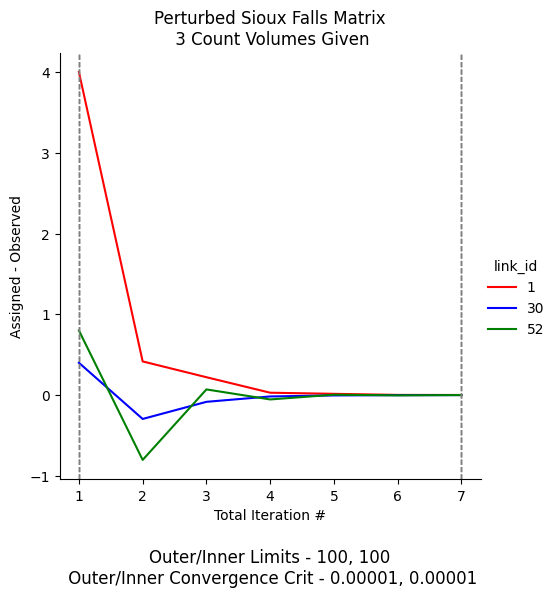

In [ ]:
palette = {1: "red", 30: "blue", 52: "green"}
sns.relplot(x='Total Iteration #',
    y='Assigned - Observed',
    hue='link_id', 
    kind='line', 
    data=stats_3, 
    palette=palette,
    markers=True, 
    dashes=False)

fig_size = plt.gcf().get_size_inches()
plt.figtext(0.5, -0.3 / fig_size[1],
    "Outer/Inner Limits - 100, 100\n Outer/Inner Convergence Crit - 0.00001, 0.00001", 
    ha='center', va='center', fontsize=12, color='black')
plt.title("Perturbed Sioux Falls Matrix\n 3 Count Volumes Given")

#plt.ylim(-0.2, 1)

for i in total_iter_outers:
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=1)

plt.savefig('/workspaces/aequilibrae/odme_plots/plot_6.png', bbox_inches='tight')

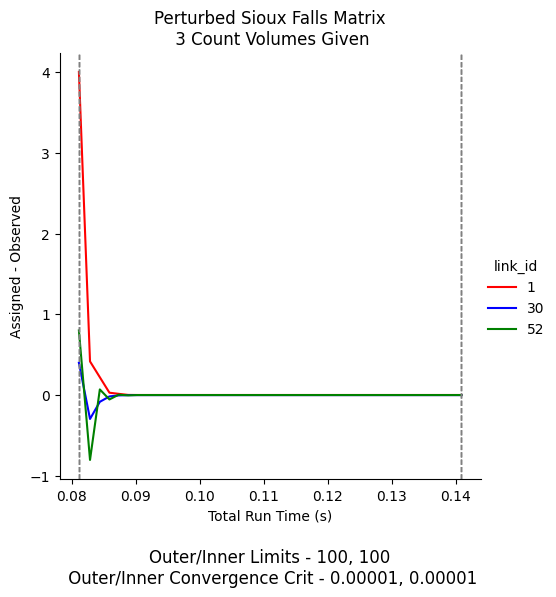

In [ ]:
palette = {1: "red", 30: "blue", 52: "green"}
sns.relplot(x='Total Run Time (s)',
    y='Assigned - Observed',
    hue='link_id', 
    kind='line', 
    data=stats_3, 
    palette=palette,
    markers=True, 
    dashes=False)

fig_size = plt.gcf().get_size_inches()
plt.figtext(0.5, -0.3 / fig_size[1],
    "Outer/Inner Limits - 100, 100\n Outer/Inner Convergence Crit - 0.00001, 0.00001", 
    ha='center', va='center', fontsize=12, color='black')
plt.title("Perturbed Sioux Falls Matrix\n 3 Count Volumes Given")

for i in time_outers:
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=1)

In [ ]:
outer_timing = stats_3[(stats_3["Inner Loop #"] == 0) & (stats_3["link_id"] == 1)]["Loop Time (s)"]
print("Outer Loop statistics:")
print(outer_timing.describe())
print("Total time taken on outer loops: ", outer_timing.sum(), "s", sep='')

Outer Loop statistics:
count    2.000000
mean     0.065896
std      0.021498
min      0.050694
25%      0.058295
50%      0.065896
75%      0.073497
max      0.081098
Name: Loop Time (s), dtype: float64
Total time taken on outer loops: 0.1317923069000243s


In [ ]:
inner_timing = stats_3[(stats_3["Inner Loop #"] != 0) & (stats_3["link_id"] == 1)]["Loop Time (s)"]
print("Inner Loop statistics:")
print(inner_timing.describe())
print("Total time taken on inner loops: ", inner_timing.sum(), "s", sep='')

Inner Loop statistics:
count    6.000000
mean     0.001521
std      0.000114
min      0.001426
25%      0.001449
50%      0.001494
75%      0.001526
max      0.001738
Name: Loop Time (s), dtype: float64
Total time taken on inner loops: 0.0091238021850583s


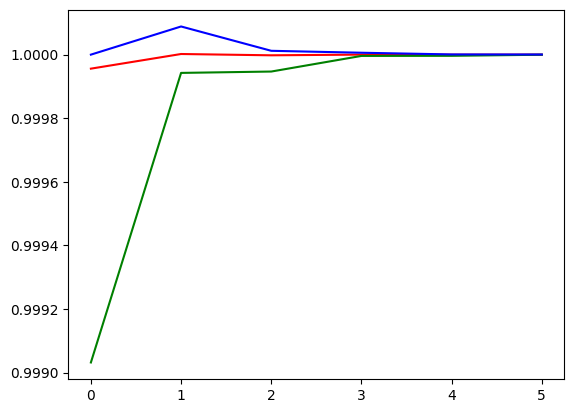

In [ ]:
plt.plot(factors_3['Total Inner Iteration #'], factors_3['mean'], color="red")
plt.plot(factors_3['Total Inner Iteration #'], factors_3['min'], color="green")
plt.plot(factors_3['Total Inner Iteration #'], factors_3['max'], color="blue")

In [ ]:
print(factors_3['mean'])

0    0.999956
1    1.000002
2    0.999998
3    1.000000
4    1.000000
5    1.000000
Name: mean, dtype: float64
